In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, tensor
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

# Understanding Early Stopping, LR Finders, PyTorch Hooks, BatchNorm and LSUV

## Initial Setup

In [3]:
# As before we'll begin with the creation of a Dataset class
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [4]:
# Accuracy measuring function
def accuracy(output, batch_label):
    return (torch.argmax(output, dim=1)==batch_label).float().mean()

In [5]:
# Setting up our get_data() function
MNIST_URL = "http://deeplearning.net/data/mnist/mnist.pkl"

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as file:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(file, encoding='latin-1')
        return map(tensor, (x_train, y_train, x_valid, y_valid))

In [6]:
# From the Callbacks notebook, we'll use the DataBunch() class to create batches
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self):
        return self.train_dl.dataset
    
    @property
    def valid_ds(self):
        return self.valid_ds.dataset
    
# get_dls() returns dataloader for the training and validation batches
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs , shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [7]:
# Downloading data
x_train, y_train, x_valid, y_valid = get_data()
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

# No. of hidden layers, batch size, FL activations and loss function
nh, bs = 50, 512
c = y_train.max().item() + 1
loss_func = F.cross_entropy

In [8]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [9]:
# Creating data bunches
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

## Improved Callback Cancellation

Here we will implement exceptions as a form of control flow statements.

In [10]:
# camel2snake function
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])(A-Z)')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [11]:
class Callback():
    _order = 0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    # Refactoring from Runner
    # Makes more sense to be inside the Callback class
    # This allows users more flexibility to control their callback 
    # implementations
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False
    

In [12]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs = 0.
        self.run.n_iter = 0
        
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter += 1
        
    def begin_epoch(self):
        self.run.n_epochs = self.epoch
        self.model.train()
        self.run.in_train = True
        
    def begin_validate(self):
        self.model.eval()
        self.run.in_train = False
        
# Creating exception classes to allow callbacks to cancel
# at one of the levels below. This way exception management becomes
# an extremely effective flow control tool.
class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [13]:
# Creating listify function which will be used in the Runner
from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [14]:
# Refactoring the Runner class and adding the new exceptions from above
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        self.in_train = False
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) or res
        return res

In [15]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data

def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

learn = create_learner(get_model, loss_func, data)

In [16]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter >= 10: raise CancelTrainException()

In [17]:
run = Runner(cb_funcs=TestCallback)

In [18]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


## Additional Callbacks

These additinal callbacks will handle Average Stats, Learning Rate Recording and Parameter Scheduling.

In [19]:
# Importing and setting seaborn for improved plots
import seaborn as sns; sns.set(style='white')

In [20]:
class AvgStats():
    def __init__(self, metrics, in_train):
        self.metrics, self.in_train = listify(metrics), in_train
        
    def reset(self):
        self.tot_loss, self.count = 0., 0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
    
    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i, m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

In [21]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)
        
class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups]
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

## Creating an LR Finder

The lesson notebooks recommend that we will also have to add a method to save the model before running the LR Finder, and then load back after running in order to preserve the weights.

In [22]:
class LR_Finder(Callback):
    _order = 1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter, self.min_lr, self.max_lr = max_iter, min_lr, max_lr
        self.best_loss = 1e9
        
    def begin_batch(self):
        if not self.in_train: return
        pos = self.n_iter / self.max_iter
        lr = self.min_lr * (self.max_lr / self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        # Here exponential smoothing can be used on the loss where we
        # would use best_loss*3 instead of best_loss*10.
        if self.n_iter >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [23]:
learn = create_learner(get_model, loss_func, data)

In [24]:
run = Runner(cb_funcs=[LR_Finder, Recorder])

In [25]:
run.fit(3, learn)

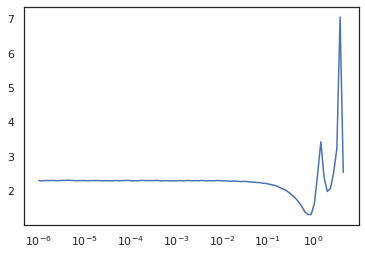

In [26]:
run.recorder.plot(skip_last=5)

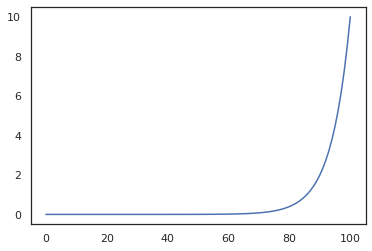

In [27]:
run.recorder.plot_lr()

## Setting up our Convolutional Network

In [28]:
x_train, y_train, x_valid, y_valid = get_data()

In [29]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [30]:
torch.set_num_threads(2)

Let's normalize our training data...

In [31]:
def normalize(x, mean, std):
    return (x - mean) / std

def normalize_to(train, valid):
    mean, std = train.mean(), train.std()
    return normalize(train, mean, std), normalize(valid, mean, std)

In [32]:
x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [33]:
# Checking the results of normalizing
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

So far, so good!

In [34]:
# Redefining our architecture, activations and loss function
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

**In lesson 11, Jeremy highlights the fact that it is useful to have a `Lambda` layer that can take a function and convert it to a layer which can be put in `nn.Sequential`.**

**Also, if we use a Lambda layer with a lambda function, our model won't be able to pickle and we won't be able to save it with PyTorch. Naming conventions are important when assigning a function inside the Lambda for e.g. flatten.**

In [35]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x): return self.func(x)
    
def flatten(x):
    return x.view(x.shape[0], -1)

In [36]:
# This function takes a flat vector of size bs x 784 and 
# puts it back as a batch of images of 28 x 28.
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [37]:
# Defining a simple CNN
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d(1,8,5, padding=2, stride=2), #14
        nn.ReLU(),
        nn.Conv2d(8,16,3, padding=1, stride=2), #7
        nn.ReLU(),
        nn.Conv2d(16,32,3, padding=1, stride=2), #4
        nn.ReLU(),
        nn.Conv2d(32,32,3, padding=1, stride=2), #2
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c)
    )

In [38]:
model = get_cnn_model(data)

In [39]:
from functools import partial

# Utilizing our callbacks
cbfs = [Recorder, partial(AvgStatsCallback, accuracy)]

In [40]:
# Setting our optimizer, learner, and runner
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [41]:
%time run.fit(1, learn)

train: [2.1535815625, tensor(0.2546)]
valid: [1.6439880859375, tensor(0.3900)]
CPU times: user 3.1 s, sys: 11.5 ms, total: 3.11 s
Wall time: 1.56 s


So, apparently there was a refactoring issue with the Runner class. Have to be mindful with so many callbacks at play!!

Now, we will begin work on CUDA hooks to move our model's training to the GPU.

### Setting up CUDA Callbacks 

In [42]:
# Flexible way 
device = torch.device('cuda', 0)

In [43]:
# Introducing the CUDA callback class with added flexibility
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): 
        self.run.xb, self.run.yb = self.xb.to(self.device), self.yb.to(self.device)

In [44]:
torch.cuda.set_device(device)

In [45]:
# Less Flexible but more convenient
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb, self.run.yb = self.xb.cuda(), self.yb.cuda()

In [46]:
cbfs.append(CudaCallback) # Add to listified callbacks

In [47]:
model = get_cnn_model(data)

In [48]:
opt = optim.SGD(model.parameters(), lr=0.04)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [49]:
%time run.fit(3, learn)

train: [2.3051903125, tensor(0.1242, device='cuda:0')]
valid: [2.303483203125, tensor(0.1091, device='cuda:0')]
train: [2.30095234375, tensor(0.1138, device='cuda:0')]
valid: [2.30018203125, tensor(0.1064, device='cuda:0')]
train: [2.29768203125, tensor(0.1136, device='cuda:0')]
valid: [2.29644921875, tensor(0.1064, device='cuda:0')]
CPU times: user 3.55 s, sys: 351 ms, total: 3.9 s
Wall time: 3.23 s


## Refactor Model

In [50]:
# Regrouping all conv and relu in a single function
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [51]:
# MNIST resize in a batch transform in the form of a Callback
class BatchTransformXCallback(Callback):
    _order = 2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)
        
def view_tfm(*size):
    def _inner(x): return x.view(*((-1,) + size))
    return _inner

In [52]:
mnist_view = view_tfm(1, 28, 28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

According to the lessons, with the `AdaptiveAvgPool`, this model can be made to work on any size input:

In [53]:
nfs = [8, 16, 32, 32]

In [54]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs):
    return nn.Sequential(*get_cnn_layers(data, nfs))

**This helper function will give us everything we need to run the training.**

In [55]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None:
        opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [56]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [57]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [58]:
run.fit(5, learn)

train: [1.77931703125, tensor(0.3891, device='cuda:0')]
valid: [0.628388427734375, tensor(0.8063, device='cuda:0')]
train: [0.3656702734375, tensor(0.8902, device='cuda:0')]
valid: [0.1762215087890625, tensor(0.9462, device='cuda:0')]
train: [0.165036328125, tensor(0.9492, device='cuda:0')]
valid: [0.143535791015625, tensor(0.9564, device='cuda:0')]
train: [0.128840009765625, tensor(0.9611, device='cuda:0')]
valid: [0.10218936767578125, tensor(0.9707, device='cuda:0')]
train: [0.1004409765625, tensor(0.9699, device='cuda:0')]
valid: [0.09588060302734375, tensor(0.9715, device='cuda:0')]


## Hooks

This is where we can truly take advantage of PyTorch's flexibility .


Assuming we want to do some telemetry, while wanting the mean and standard devation of each activation in the model.

The following method is when we want to do this manually:

### Manual Insertion


In [59]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds[i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

Initializing the model with an exaggerated LR for the purpose of illustration: 

In [60]:
model = SequentialModel(*get_cnn_layers(data, nfs))
learn, run = get_runner(model, data, lr=0.7, cbs=cbfs)

In [61]:
run.fit(3, learn)

train: [1.99267734375, tensor(0.3200, device='cuda:0')]
valid: [1.238442578125, tensor(0.6746, device='cuda:0')]
train: [0.4788908203125, tensor(0.8483, device='cuda:0')]
valid: [0.1826483154296875, tensor(0.9446, device='cuda:0')]
train: [0.1703858203125, tensor(0.9484, device='cuda:0')]
valid: [0.12164986572265625, tensor(0.9636, device='cuda:0')]


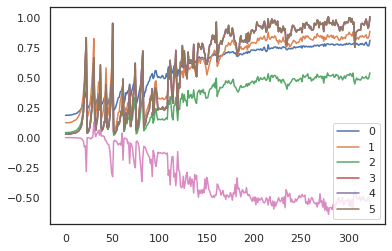

In [62]:
for l in model.act_means:
    plt.plot(l)
plt.legend(range(6));

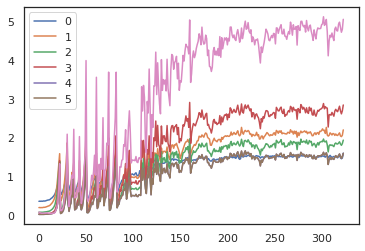

In [63]:
for l in model.act_stds:
    plt.plot(l)
plt.legend(range(6));

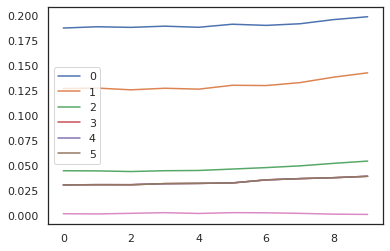

In [64]:
for l in model.act_means:
    plt.plot(l[:10])
plt.legend(range(6))

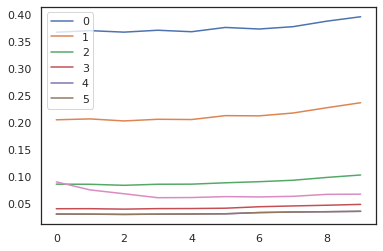

In [65]:
for l in model.act_stds:
    plt.plot(l[:10])
plt.legend(range(6));

#### **PyTorch Hooks**

In [66]:
# With PyTorch hooks we won't need to refactor the entire model.
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [67]:
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

Hooks need to be attached to a layer, and need functions which take three arguments : 
- module 
- input 
- output. 

Here we store the mean and std of the output in the correct position of our list.

In [68]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())
    

In [69]:
for i, m in enumerate(model):
    m.register_forward_hook(partial(append_stats, i))

In [70]:
run.fit(3, learn)

train: [2.30787234375, tensor(0.1357, device='cuda:0')]
valid: [2.2981828125, tensor(0.1064, device='cuda:0')]
train: [1.66391328125, tensor(0.3998, device='cuda:0')]
valid: [0.777379052734375, tensor(0.7378, device='cuda:0')]
train: [0.3469921875, tensor(0.8938, device='cuda:0')]
valid: [0.17910499267578125, tensor(0.9450, device='cuda:0')]


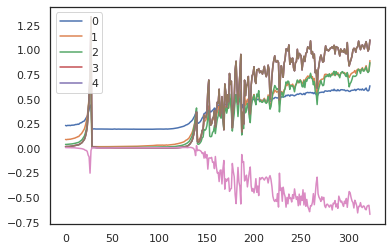

In [71]:
for l in act_means:
    plt.plot(l)
plt.legend(range(5));

#### **Hooks as Classes**

While refactoring the above in a Hook class it's very important to remember to: 
- Remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

Jeremy's notes mention the fact that fastai uses a `bool` parameter to choose whether to make it a forward or backward hook. We will only be looking a forward hook implementation for now.

Making a backward hook would be a cool practice assignment!!

In [72]:
def children(m): 
    return list(m.children())

class Hook():
    def __init__(self, m, f): 
        self.hook = m.register_forward_hook(partial(f, self))
    
    def remove(self):
        self.hook.remove()
    
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [])
    means, stds = hook.stats
    means.append(outp.data.mean())
    stds.append(outp.data.std())

In [73]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [74]:
hooks = [Hook(l, append_stats) for l in children(model[:5])]

In [75]:
run.fit(3, learn)

train: [1.99093671875, tensor(0.2890, device='cuda:0')]
valid: [1.14399462890625, tensor(0.6039, device='cuda:0')]
train: [0.4079205078125, tensor(0.8696, device='cuda:0')]
valid: [0.1836734130859375, tensor(0.9446, device='cuda:0')]
train: [0.163490224609375, tensor(0.9501, device='cuda:0')]
valid: [0.12424320068359375, tensor(0.9640, device='cuda:0')]


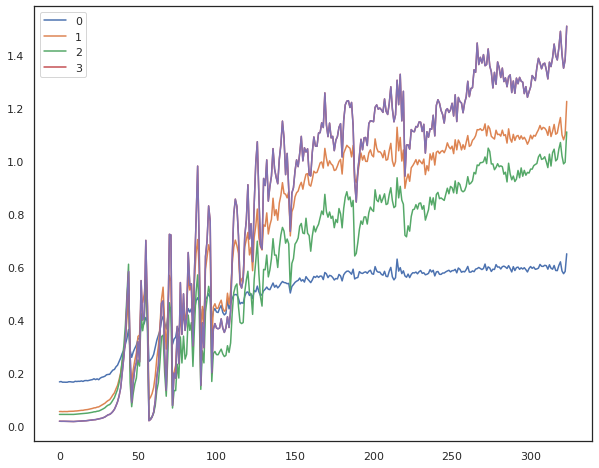

In [76]:
plt.figure(figsize=(10,8))

for hook in hooks:
    plt.plot(hook.stats[0])
    hook.remove()

plt.legend(range(4));

#### **A Composite Hooks Class**

This class can contain a list of objects and will behave like a numpy array where we can index into it via:

- a single index
- a slice(like 1:5)
- a list of indeces
- a mask of indeces

In [77]:
class ListContainer():
    def __init__(self, items): 
        self.items = listify(items)
        
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], bool):
            assert len(idx)==len(self) #boolean mask
            return [o for m,o in zip(idx, self.items) if m]
        return [self.items[i] for i in idx]
    
    def __len__(self): return len(self.items)
    
    def __iter__(self): return iter(self.items)
    
    def __setitem(self, i, o): self.items[i] = o
    
    def __delitem__(self, i): del(self.items[i])
        
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self) > 10:
            res = res[:-1] + '...]'
        return res

In [78]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [79]:
ListContainer(range(200))

ListContainer (200 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [80]:
# We can even run checks
t = ListContainer(range(10))
t[[1, 2]], t[[False]*8 + [True, False]]

([1, 2], [8])

**We will now use the `ListContainer` to write a Hooks class that contains numerous hooks. This will also be used as a container for our objects once we look into the datablock API.**

In [81]:
from torch.nn import init 

class Hooks(ListContainer):
    def __init__(self, ms, f):
        super().__init__([Hook(m, f) for m in ms])
    
    # The enter and exit methods in this class allow us to use it as
    # a context manager i.e. once we are out of the 'with' block, all the 
    # hooks are removed and memory is subsequently cleared.
    
    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args):
        self.remove()
        
    def __del__(self):
        self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self:
            h.remove()

In [82]:
model = get_cnn_model(data, nfs).cuda()
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [83]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fba404b1c90>, <__main__.Hook object at 0x7fba404b1450>, <__main__.Hook object at 0x7fba404b1610>, <__main__.Hook object at 0x7fba404b1f10>, <__main__.Hook object at 0x7fba404b1490>, <__main__.Hook object at 0x7fba401e7e50>, <__main__.Hook object at 0x7fba401e2e50>]

In [84]:
hooks.remove()

In [85]:
x, y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [86]:
x.mean(), x.std()

(tensor(-0.0163, device='cuda:0'), tensor(0.9818, device='cuda:0'))

In [87]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.1682, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.3629, device='cuda:0', grad_fn=<StdBackward0>))

In [88]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [89]:
p = model[0](x)
p.mean(), p.std()

(tensor(0.4145, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.6709, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.297163046875, tensor(0.5691, device='cuda:0')]
valid: [0.24067724609375, tensor(0.9257, device='cuda:0')]
train: [0.22009267578125, tensor(0.9324, device='cuda:0')]
valid: [0.1440914794921875, tensor(0.9567, device='cuda:0')]


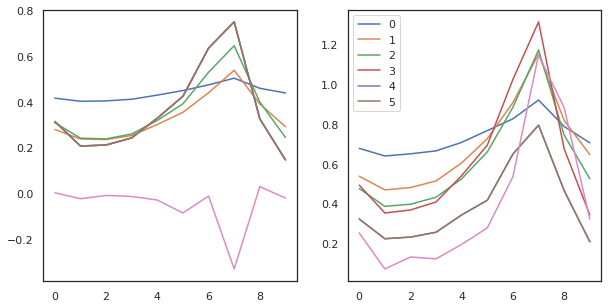

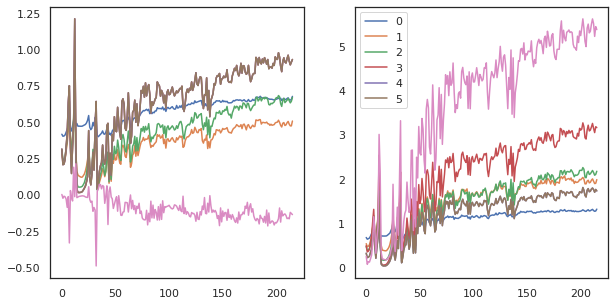

In [90]:
# As mentioned above, once the 'with' block has run it's course the enter and exit
# methods allow it's usage as a context manager.
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));

    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10, 5))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

#### **Additional Statistics**

In [ ]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'):
        hook.stats = ([], [], [])
    means, stds, hists